In [1]:
%reload_ext autoreload
%autoreload 2

import math
import os
import random

import sys
sys.path.append('./code')
from parsed_args import args

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as Data
from torch.autograd import Variable
from torch.utils.data import Dataset
import math
from tqdm import tqdm
import warnings 
warnings.filterwarnings("ignore")
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score, roc_auc_score

from vae_train.vae_utils import *
from code.dataset_iterators import *

torch.manual_seed(0)
np.random.seed(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False


In [2]:
%load_ext autoreload
%autoreload 2
from vae_train.vae_model import HierachyVAE
from lstm_train.lstm_model import AttnContentStrategy
from read_data import *
from utils import *
from collections import defaultdict
from editing_utils import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## First, we'll check the labeled data distribution!
### Table 1

In [3]:
with open(args.data_path + 'labeled_data.pkl', 'rb') as f:
    labeled_data_pkl = pickle.load(f)
with open(args.data_path + 'unlabeled_data.pkl', 'rb') as f:
    unlabeled_data_pkl = pickle.load(f)

In [4]:
len(unlabeled_data_pkl) + len(labeled_data_pkl)

49855

The labeled data pkl is structured as follows:
```
[[sentences, labels], [sentences, labels], ...]
```
Here, we extract the labels and count how frequently they appear

In [5]:
def get_label_distribution(labeled_data_pkl):
    sentence_labels = [labeled_data_pkl[k][1] for k in labeled_data_pkl]
    freq = defaultdict(int)
    for sent in sentence_labels:
        for strategy in sent:
            freq[strategy] += 1
            
    tot = sum(freq[strategy] for strategy in freq)
    for strategy in freq:
        freq[strategy] = freq[strategy] / tot
    return freq

In [6]:
get_label_distribution(labeled_data_pkl)

defaultdict(int,
            {3: 0.38982758620689656,
             2: 0.17517241379310344,
             0: 0.05672413793103448,
             1: 0.07879310344827586,
             8: 0.11724137931034483,
             9: 0.16,
             6: 0.0017241379310344827,
             5: 0.010344827586206896,
             7: 0.01,
             4: 0.00017241379310344826})

We actually started with a larger set of labels than originally presented in the paper;
however, these labels were eventually merged to the subset that appears in our work. This bit does a little merging.

In [7]:
# these are all our proposed strategies
all_strategies = ['Other', 'Cred', 'Recip', 'Concret', 'Commit', 'Scar', 'Identit', 'Emo', 'Impac', 'Polit']

with open(args.data_path + 'label_mapping.pkl', 'rb') as f:
    label_mapping = pickle.load(f)

def merge_labels(label_mapping, all_strats, freq):
    # build an inverse mapping from the label_mapping pkl
    inverse_label_mapping = {}
    for key in label_mapping:
        value = label_mapping[key] 
        if value in inverse_label_mapping:
            inverse_label_mapping[value] = 0
        else:
            inverse_label_mapping[value] = key
            
    # select the subset that we use from all_strategies 
    selected = [1, 2, 3, 8, 9]
    merged = {}
    for i in selected: merged[all_strats[i]] = 0
    merged["other"] = 0

    for k in freq:
        if k in selected:
            merged[all_strats[k]] += freq[k]
        else:
            merged["other"] += freq[k]
    
    return merged, inverse_label_mapping

merged, inverse_label_mapping = merge_labels(label_mapping, all_strategies, get_label_distribution(labeled_data_pkl))
print(merged)

{'Cred': 0.07879310344827586, 'Recip': 0.17517241379310344, 'Concret': 0.38982758620689656, 'Impac': 0.11724137931034483, 'Polit': 0.16, 'other': 0.0789655172413793}


## Now, we'll extract the content and strategy vectors from our VAE model.
#### Section 2, Modeling Part

In [8]:
os.environ['CUDA_VISIBLE_DEVICES'] = "6"
use_cuda = torch.cuda.is_available()
devices = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()
print("gpu num: ", n_gpu)

gpu num:  1


In [9]:
print(args.data_path)

./data/borrow/


In [10]:
train_labeled_dataset, train_unlabeled_dataset, test_dataset, val_dataset, vocab, n_labels, doc_labels = read_data(
    data_path=args.data_path, n_labeled_data=args.n_labeled_data, n_unlabeled_data=args.n_unlabeled_data, max_seq_num=args.max_seq_num, max_seq_len=args.max_seq_len, embedding_size=args.embedding_size)

dist = train_labeled_dataset.esit_dist

labeled_trainloader = Data.DataLoader(
    dataset=train_labeled_dataset, batch_size=args.batch_size, shuffle=True)
unlabeled_trainloader = Data.DataLoader(
    dataset=train_unlabeled_dataset, batch_size=args.batch_size_u, shuffle=True)
val_loader = Data.DataLoader(
    dataset=val_dataset, batch_size=16, shuffle=False)
test_loader = Data.DataLoader(
    dataset=test_dataset, batch_size=16, shuffle=False)

model = HierachyVAE(vocab.vocab_size, args.embedding_size, args.n_highway_layers, args.encoder_hidden_size, args.encoder_layers, args.generator_hidden_size, args.generator_layers, args.z_size, n_labels, doc_labels, args.bidirectional, vocab.embed, args.hard).cuda()
model = nn.DataParallel(model).cuda()
model.load_state_dict(torch.load(args.data_path + 'model_state.pkl'))
model.eval()


{0: 0, 1: 1, 2: 2, 3: 3, 4: 0, 5: 0, 6: 0, 7: 0, 8: 4, 9: 5}
unk words:  9516
vocab size:  13944
#Labeled: 900, Unlabeled 48155, Val 400, Test 400, N class 6, 2


DataParallel(
  (module): HierachyVAE(
    (embedding): Embedding(13944, 128)
    (encoder): Encoder(
      (lstm): LSTM(128, 128, batch_first=True)
    )
    (hidden_to_mu): Linear(in_features=70, out_features=64, bias=True)
    (hidden_to_logvar): Linear(in_features=70, out_features=64, bias=True)
    (hidden_linear): Linear(in_features=128, out_features=64, bias=True)
    (classifier): Linear(in_features=128, out_features=6, bias=True)
    (predictor): Predictor(
      (embedding): Linear(in_features=6, out_features=64, bias=False)
      (lstm): LSTM(70, 64, batch_first=True)
      (predict): Linear(in_features=64, out_features=2, bias=True)
    )
    (generator): Generator(
      (lstm): LSTM(198, 128, batch_first=True)
      (linear): Linear(in_features=128, out_features=13944, bias=True)
    )
  )
)

In [11]:
labeled_train_iter = iter(labeled_trainloader)
unlabeled_train_iter = iter(unlabeled_trainloader)
tau = args.tau

content_vectors = []
strat_vectors = []
doc_labels = []
mappings = []
orig_fetch = []
for batch_idx in tqdm(range(args.val_iteration), position=0, leave=True):
    try:
        x, l, y, mask1, mask2, mask3, mask4, mid, sent_len, doc_len = labeled_train_iter.next()

    except:
        labeled_train_iter = iter(labeled_trainloader)
        x, l, y, mask1, mask2, mask3, mask4, mid, sent_len, doc_len = labeled_train_iter.next()

    try:
        x_u, l_u, y_u, mask1_u, mask2_u, mask3_u, mask4_u, mid_u, sent_len_u, doc_len_u = unlabeled_train_iter.next()

    except:
        unlabeled_train_iter = iter(unlabeled_trainloader)
        x_u, l_u, y_u, mask1_u, mask2_u, mask3_u, mask4_u, mid_u, sent_len_u = unlabeled_train_iter.next()

    x = torch.cat([x, x_u], dim = 0)
    l = torch.cat([l, l_u], dim = 0)
    y = torch.cat([y.long(), y_u.long()], dim = 0)

    mask1 = torch.cat([mask1, mask1_u], dim = 0)
    mask2 = torch.cat([mask2, mask2_u], dim = 0)
    mask3 = torch.cat([mask3, mask3_u], dim = 0)
    mask4 = torch.cat([mask4, mask4_u], dim = 0)

    doc_len = torch.cat([doc_len, doc_len_u], dim = 0)
    sent_len = torch.cat([sent_len, sent_len_u], dim = 0)

    batch_size = l.shape[0]
    seq_num = x.shape[1]
    seq_len = x.shape[2]

    mid = mid + mid_u

    temp = l.view(-1, 1).long()
    l_one_hot = torch.zeros(batch_size*seq_num, n_labels).cuda()

    for i in range(0, len(temp)):
        if temp[i] != 10:
            l_one_hot[i][temp[i]] = 1

    l_one_hot = l_one_hot.view(batch_size, seq_num, n_labels)

    if batch_idx % 30 == 1:
        tau = np.maximum(tau * np.exp(-args.anneal_rate*batch_idx), args.tau_min)

    xs, ys = (x.view(batch_size*seq_num, seq_len), l.view(batch_size*seq_num))
    prob = create_generator_inputs(xs, vocab, train = False)


    x, prob, l_one_hot, y, l = x.cuda(), prob.cuda(), l_one_hot.cuda(), y.cuda(), l.cuda()
    mask1, mask2 = mask1.cuda(), mask2.cuda()

    logits, kld_z, q_y, q_y_softmax, t, strategy_embedding, y_in2, content_vec = model(x, prob, args.tau, 
        mask1, mask2, args.hard, l_one_hot, doc_len = doc_len, sent_len = sent_len)
    
    max_idxs = y_in2.argmax(axis=1)
    argmaxed = torch.zeros(y_in2.shape)
    argmaxed[torch.arange(y_in2.shape[0]),max_idxs] = 1
    y_in2 = (argmaxed.T.cpu() * y_in2.sum(axis=1).cpu()).T
    
    last_dim = int((content_vec.shape[0] * content_vec.shape[1]) / (batch_size * seq_num))
    content_vectors.append(content_vec.reshape((batch_size, seq_num, last_dim)).tolist())
    strat_vectors.append(y_in2.reshape(batch_size, seq_num, n_labels).tolist())
    doc_labels.append(y.tolist())
    orig_fetch.append(mid)    

100%|██████████| 120/120 [00:52<00:00,  2.30it/s]


#### Here is where our LSTM Model would also be trained (on content and strat vec tensors)

In [12]:
test_model = AttnContentStrategy(n_labels)
test_model.cuda()
test_model.load_state_dict(torch.load("best_borrow_model.pkl"))
test_model.eval()

AttnContentStrategy(
  (linearStrategy): Linear(in_features=6, out_features=64, bias=True)
  (linearStrategy2): Linear(in_features=64, out_features=64, bias=True)
  (linearContent): Linear(in_features=64, out_features=64, bias=True)
  (linearContent2): Linear(in_features=64, out_features=64, bias=True)
  (content_proj): Linear(in_features=64, out_features=64, bias=True)
  (strat_proj): Linear(in_features=64, out_features=64, bias=True)
  (linear1): Linear(in_features=128, out_features=256, bias=True)
  (linear2): Linear(in_features=256, out_features=512, bias=True)
  (lstm): LSTM(512, 512)
  (s_proj): Linear(in_features=512, out_features=512, bias=True)
  (softmax): Softmax(dim=1)
  (sent_linear1): Linear(in_features=512, out_features=256, bias=True)
  (sent_linear2): Linear(in_features=256, out_features=128, bias=True)
  (sent_linear3): Linear(in_features=128, out_features=1, bias=True)
)

In [13]:
test_details = get_dataloader_details(test_loader, model, 
                                       test_model, n_labels, vocab)

val_details = get_dataloader_details(val_loader, model, 
                                       test_model, n_labels, vocab)

train_details = get_content_strat_vector_details(content_vectors, strat_vectors, 
                                        doc_labels, orig_fetch, test_model)

# detailers return the following:
# f1_score(all_corr, all_out, average="macro"), attns, labels, strategy_orders, all_mids
# acc, attn_content_arr, attn_strat_arr, s_score_arr, attn_aud_arr, attn_msg_arr, labels, strategy_orders, orig_fetch

25it [00:02,  9.64it/s]
2it [00:00, 10.86it/s]

0.6136089923725412 f1
0.6141304347826086 p
0.6135817307692308 r
0.615 acc
0.6135817307692308 roc auc


25it [00:02, 10.74it/s]


0.608345258718084 f1
0.6086956521739131 p
0.6082706766917294 r
0.61 acc
0.6082706766917294 roc auc


## Now, we'll look at correlations between success rate and strategy attention
#### Section 3, Content-Strategy interplay

In [14]:
import matplotlib.pyplot as plt

In [15]:
# datasets is an array of detailers.
def get_strategy_attn_freqs(datasets):
    freq_all = defaultdict(int)
    freq_success = defaultdict(int)
    freq_fail = defaultdict(int)
    strat_attns = {}

    all_attn_vals = []
    
    for dataset in datasets:
        for i, batch_content in enumerate(dataset[-3]):
            for j, label in enumerate(batch_content):
                attns = dataset[1]
                doc_level_attn = attns["document"][i][j].squeeze()
                strategy_level_attn = attns["strategy"][i][j].squeeze()
                strategy_orders = dataset[-2][i][j]
                
                # strat arg will contain the relevant ordering
                strat_arg = []
                
                # sum attn is just for the stat in the paper that shows the model focusing on a single triplet.
                sum_attn = 0
                # extract the most important sentence to find the "middle" of the triplet
                important_sent = (doc_level_attn.argmax())
                all_attn_vals.append(doc_level_attn[important_sent].tolist())
                
                # handle the left of the triplet
                if important_sent == 0:
                    strat_arg.append("UNK")
                else:
                    strat_arg.append(strategy_orders[important_sent - 1].argmax().tolist())
                    sum_attn += strategy_level_attn[important_sent - 1].tolist()

                # handle the middle triplet        
                strat_arg.append(strategy_orders[important_sent].argmax().tolist())
                
                # are we exceeding the sentence length? sum(strategy_orders) == 0 will tells us that.
                if important_sent >= strategy_orders.shape[0] - 1 or sum(strategy_orders[important_sent + 1]) == 0:
                    strat_arg.append("UNK")
                else:
                    strat_arg.append(strategy_orders[important_sent + 1].argmax().tolist())
                    sum_attn += strategy_level_attn[important_sent + 1].tolist()
                
                curr_attn = strategy_level_attn[important_sent].tolist()
                sum_attn += curr_attn

                strat_key = " ".join([str(x) for x in strat_arg])
        
                if strat_key not in strat_attns:
                    strat_attns[strat_key] = {
                        "triplet_strategy_attn": 0,
                        "freq": 0,
                        "label": []
                    }
                
                strat_attns[strat_key]["triplet_strategy_attn"] += (sum_attn / 3) #curr_attn
                strat_attns[strat_key]["freq"] += 1
                strat_attns[strat_key]["label"].append(dataset[-1][i][j])
        
                if label: freq_success[strat_key] += 1                    
                else: freq_fail[strat_key] += 1
                
                freq_all[strat_key] += 1  
    
    return freq_all, freq_success, freq_fail, strat_attns, all_attn_vals

In [16]:
freq_all, freq_success, freq_fail, strat_attns, attn_vals = get_strategy_attn_freqs([train_details, val_details, test_details])

In [17]:
fixed_attns = {strat: (strat_attns[strat]["triplet_strategy_attn"] / strat_attns[strat]["freq"]) for strat in strat_attns}

In [18]:
# all k values here are "strategies"
sorted_success = {k: v for k, v in sorted(freq_success.items(), key=lambda item: item[1], reverse=True)}
sorted_fail = {k: v for k, v in sorted(freq_fail.items(), key=lambda item: item[1], reverse=True)}
sorted_strat_attn = {k: v for k, v in sorted(fixed_attns.items(), key=lambda item: item[1], reverse=True)}

In [19]:
throw_out = 0
success_rate = {}
for k in freq_all:
    v = freq_all[k]
    if v >= 60 and '0' not in k:
        success_rate[k] = freq_success[k] / freq_all[k]
    else:
        throw_out += v

In [20]:
throw_out / sum([freq_all[k] for k in freq_all])

0.30839338702840186

In [21]:
sorted_success_rate = {k: v for k, v in sorted(success_rate.items(), key=lambda item: item[1], reverse=True)}

In [22]:
merged_strats = {}
for k in sorted_success_rate:
    merged_strats[k] = [sorted_success_rate[k], sorted_strat_attn[k], strat_attns[k]["label"]]

In [23]:
rate_success_line = []
attn_success_line = []
for i in merged_strats:
    rate_success_line.append(merged_strats[i][0])
    attn_success_line.append(merged_strats[i][1])


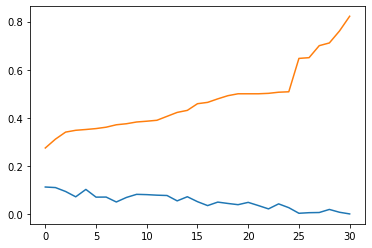

In [24]:
plt.plot(range(0, len(attn_success_line[::-1])), attn_success_line[::-1])
plt.plot(range(0, len(attn_success_line[::-1])), rate_success_line[::-1])

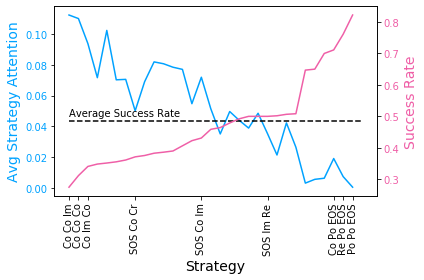

In [25]:
labels = []
from random import sample 
for k in merged_strats:
    samp_keys = merged_strats[k][-1]
    converted_samp = ""
    for idx, curr_strat in enumerate(k.split(" ")):
        if curr_strat == "UNK":
            if idx == 0: converted_samp += "SOS" + " "
            else: converted_samp += "EOS" + " "
        else:
            converted_samp += all_strategies[inverse_label_mapping[int(curr_strat)]][:2] + " "
    labels.append(converted_samp[:-1])

str_labels = labels[:][::-1]

xvals = [0, 1, 2, 7, 14, 21, 28, 29, 30]

selected_labels = [str_labels[x] for x in xvals]

fig, ax1 = plt.subplots()
plt.xticks(xvals, selected_labels, rotation=90)

t = range(0, len(attn_success_line[:][::-1]))
color = '#00A2FF'
ax1.set_xlabel('Strategy', fontsize=14)
ax1.set_ylabel('Avg Strategy Attention', color=color, fontsize=14)
ax1.plot(t, attn_success_line[:][::-1], color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = '#EF5FA7'
ax2.set_ylabel('Success Rate', color=color, fontsize=14)  # we already handled the x-label with ax1
ax2.plot(t, rate_success_line[:][::-1], color=color)
ax2.tick_params(axis='y', labelcolor=color)
ax2.hlines(.485, xmin=0, xmax=31, linestyles='dashed', label="baseline")
fig.tight_layout()  # otherwise the right y-label is slightly clipped
# plt.show()

plt.text(0,.5,'Average Success Rate',rotation=0)
plt.savefig("color.png",  bbox_inches='tight')


In [26]:
import scipy
scipy.stats.pearsonr(rate_success_line[:][::-1], attn_success_line[:][::-1])

(-0.9020708231627488, 4.222950873877163e-12)

#### Printing all our strategies -- this is in the appendix.

In [27]:
q = 1
for k in merged_strats:
    converted_samp = ""
    for idx, curr_strat in enumerate(k.split(" ")):
        if curr_strat == "UNK":
            if idx == 0:
                converted_samp += "SOS" + " "
            else: converted_samp += "EOS" + " "
        else:
            converted_samp += all_strategies[inverse_label_mapping[int(curr_strat)]][:2] + " "
    print(str(q) + " & " + converted_samp + "& " + str(round(merged_strats[k][:][1], 2)) + " & " + str(round(merged_strats[k][:][0], 2)) + " \\\\")
    q += 1


1 & Po Po EOS & 0.0 & 0.82 \\
2 & Re Po EOS & 0.01 & 0.76 \\
3 & Co Po EOS & 0.02 & 0.71 \\
4 & Cr Po EOS & 0.01 & 0.7 \\
5 & SOS Re EOS & 0.01 & 0.65 \\
6 & SOS Po EOS & 0.0 & 0.65 \\
7 & SOS Im EOS & 0.03 & 0.51 \\
8 & Re Co EOS & 0.04 & 0.51 \\
9 & SOS Co EOS & 0.02 & 0.5 \\
10 & SOS Im Re & 0.04 & 0.5 \\
11 & Co Re EOS & 0.05 & 0.5 \\
12 & SOS Co Po & 0.04 & 0.5 \\
13 & SOS Co Re & 0.04 & 0.49 \\
14 & SOS Im Co & 0.05 & 0.48 \\
15 & SOS Im Po & 0.04 & 0.46 \\
16 & Re Co Po & 0.05 & 0.46 \\
17 & SOS Co Im & 0.07 & 0.43 \\
18 & Co Co EOS & 0.05 & 0.42 \\
19 & Re Co Co & 0.08 & 0.41 \\
20 & Po Co Co & 0.08 & 0.39 \\
21 & Co Co Re & 0.08 & 0.39 \\
22 & Im Co Re & 0.08 & 0.38 \\
23 & SOS Co Co & 0.07 & 0.38 \\
24 & SOS Co Cr & 0.05 & 0.37 \\
25 & Co Im Re & 0.07 & 0.36 \\
26 & Co Co Po & 0.07 & 0.36 \\
27 & Im Co Co & 0.1 & 0.35 \\
28 & Co Co Cr & 0.07 & 0.35 \\
29 & Co Im Co & 0.09 & 0.34 \\
30 & Co Co Co & 0.11 & 0.31 \\
31 & Co Co Im & 0.11 & 0.27 \\


## Finally, we'll edit bad strategies and see what we can do to improve them
#### Section 5, Editing Strategy Sequences

In [28]:
good_strats = ["5 5 UNK", "2 5 UNK", "3 5 UNK"]
bad_strats = ["3 4 3", "3 3 3", "3 3 4"]

In [29]:
# this method takes a map of strings and returns the attn and success rate. 
def read_all_unlabeled(limited_unlabeled_data, data_path):

    max_seq_num=args.max_seq_num
    max_seq_len=args.max_seq_len
    
    with open(data_path + 'labeled_data.pkl', 'rb') as f:
        labeled_data = pickle.load(f)
        # {mid: sentences, labels}
    with open(data_path + 'unlabeled_data.pkl', 'rb') as f:
        unlabeled_data = pickle.load(f)
        # {mid: message}
    with open(data_path + 'mid2target.pkl', 'rb') as f:
        mid2target = pickle.load(f)
        # {mid: target, team_size}
    
    with open(data_path + 'label_mapping.pkl', 'rb') as f:
        label_mapping = pickle.load(f)

    try:
        with open(data_path + 'vocab_2.pkl', 'rb') as f:
            vocab = pickle.load(f)

        print('unk words: ', vocab.unk_count)
        print('vocab size: ', vocab.vocab_size)
    except:
        vocab = Vocab(unlabeled_data=unlabeled_data,
                      labeled_data=labeled_data, embedding_size=embedding_size)

        with open(data_path + 'vocab_2.pkl', 'wb') as f:
            pickle.dump(vocab, f)

        print('unk words: ', vocab.unk_count)
        print('vocab size: ', vocab.vocab_size)

    all_ids = [k for k in limited_unlabeled_data]
    
    train_unlabeled_dataset = Loader_unlabeled(
        vocab, limited_unlabeled_data, all_ids, mid2target, max_seq_num, max_seq_len)

    train_limited_loader = Data.DataLoader(
        dataset=train_unlabeled_dataset, batch_size=16, shuffle=False)
    
    unlabeled_train_iter = iter(train_limited_loader)

    content_vectors, strat_vectors, doc_labels, orig_mids = full_iterator(unlabeled_train_iter, 
        unlabeled_trainloader, vocab, model, n_labels)
        
    subset_details = get_content_strat_vector_details(content_vectors, strat_vectors, doc_labels,
                                     None, test_model, return_rate=True)

    flatten_doc_attn = [j for i in subset_details[1]["document"] for j in i]
    flatten_sent_attn = [j for i in subset_details[1]["strategy"] for j in i]
    flatten_mid = [j for i in orig_mids for j in i]
    all_sent_attn = []

    sent_map = {}
    target_sent = []
    for i in range(0, len(flatten_doc_attn)):
        tot = 0
        sent_map[flatten_mid[i]] = flatten_doc_attn[i].argmax().tolist()
        if flatten_doc_attn[i].argmax().tolist() > 0:
            tot += flatten_sent_attn[i][flatten_doc_attn[i].argmax() - 1].squeeze().tolist()
        
        if flatten_doc_attn[i].argmax().tolist() < 6:
            tot += flatten_sent_attn[i][flatten_doc_attn[i].argmax() + 1].squeeze().tolist()
        
        tot += flatten_sent_attn[i][flatten_doc_attn[i].argmax()].squeeze().tolist()
        all_sent_attn.append(tot/3)
    
    print("average msg attn: " + str(sum(all_sent_attn) / len(all_sent_attn)))
    print("success rate: " + str(subset_details[-1]))
    return sent_map, subset_details[-1], (sum(all_sent_attn) / len(all_sent_attn))


In [30]:
bad, good = get_samples(good_strats, bad_strats, merged_strats, 
            unlabeled_data_pkl, labeled_data_pkl, all_strategies, inverse_label_mapping)
target_sents, _, _ = read_all_unlabeled(bad, args.data_path)
bad_copy = fix_bad(bad, good, target_sents)

unk words:  9516
vocab size:  13944
average msg attn: 0.10479660402196406
success rate: 0.10882956878850103


In [31]:
insertion_length = []
for k in good:
    e = sum([len(nltk.word_tokenize(x)) for x in nltk.sent_tokenize(good[k])[-2:]])
    insertion_length.append(e)

In [32]:
total_len = []
for k in bad:
    total_len.append(len(nltk.word_tokenize(bad[k])))

In [33]:
delete_len = []
for k in bad:
    sents_bad = nltk.sent_tokenize(bad[k])        
    target = target_sents[k]
    e = sum([len(nltk.word_tokenize(x)) for x in sents_bad[target-1:target+2]])
    delete_len.append(e)

In [34]:
pd.Series(delete_len).describe()

count    974.000000
mean      58.796715
std       29.682731
min        0.000000
25%       43.000000
50%       59.000000
75%       75.000000
max      262.000000
dtype: float64

In [35]:
pd.Series(total_len).describe()

count     974.000000
mean      174.388090
std       128.870974
min        23.000000
25%        93.000000
50%       138.500000
75%       214.750000
max      1613.000000
dtype: float64

In [36]:
pd.Series(insertion_length).describe()

count    775.000000
mean      12.476129
std       13.414256
min        0.000000
25%        3.000000
50%        6.000000
75%       19.000000
max      117.000000
dtype: float64

### fix_bad takes two optional params: delete=False and insert=False, as defined in the paper
### Here, we explore deletion, insertion, then deletion + insertion

In [37]:
bad_copy = fix_bad(bad, good, target_sents)
_, rate, attn = read_all_unlabeled(bad_copy, args.data_path)

unk words:  9516
vocab size:  13944
average msg attn: 0.10479660402196406
success rate: 0.10882956878850103


In [38]:
bad_copy = fix_bad(bad, good, target_sents, True)
_, rate, attn = read_all_unlabeled(bad_copy, args.data_path)

unk words:  9516
vocab size:  13944
average msg attn: 0.05553688770502318
success rate: 0.43121149897330596


In [39]:
bad_copy = fix_bad(bad, good, target_sents, False, True)
_, rate, attn = read_all_unlabeled(bad_copy, args.data_path)

unk words:  9516
vocab size:  13944
average msg attn: 0.10443263241609096
success rate: 0.10677618069815195


In [40]:
bad_copy = fix_bad(bad, good, target_sents, True, True)
_, rate, attn = read_all_unlabeled(bad_copy, args.data_path)

unk words:  9516
vocab size:  13944
average msg attn: 0.05593976073684503
success rate: 0.41478439425051333


In [41]:
case1_rate = []
case1_attn = []

case2_rate = []
case2_attn = []

case3_rate = []
case3_attn = []

case4_rate = []
case4_attn = []

for runs in tqdm(range(10)): 

    print("###################################")
    print("")
    print("")
        
    bad_copy = fix_bad(bad, good, target_sents)
    _, rate, attn = read_all_unlabeled(bad_copy, args.data_path)
    case1_rate.append(rate)
    case1_attn.append(attn)  
    
    print()
    
    bad_copy = fix_bad(bad, good, target_sents, True)
    _, rate, attn = read_all_unlabeled(bad_copy, args.data_path)
    case2_rate.append(rate)
    case2_attn.append(attn)  
    
    print()
    
    bad_copy = fix_bad(bad, good, target_sents, False, True)
    _, rate, attn = read_all_unlabeled(bad_copy, args.data_path)
    case3_rate.append(rate)
    case3_attn.append(attn)  

    print()
    
    bad_copy = fix_bad(bad, good, target_sents, True, True)
    _, rate, attn = read_all_unlabeled(bad_copy, args.data_path)
    case4_rate.append(rate)
    case4_attn.append(attn)  

  0%|          | 0/10 [00:00<?, ?it/s]

###################################


unk words:  9516
vocab size:  13944
average msg attn: 0.10479660402196406
success rate: 0.10882956878850103

unk words:  9516
vocab size:  13944
average msg attn: 0.05553688770502318
success rate: 0.43121149897330596

unk words:  9516
vocab size:  13944
average msg attn: 0.10461854308646473
success rate: 0.10882956878850103

unk words:  9516
vocab size:  13944


 10%|█         | 1/10 [00:28<04:18, 28.68s/it]

average msg attn: 0.056197923900931486
success rate: 0.4240246406570842
###################################


unk words:  9516
vocab size:  13944
average msg attn: 0.10479660402196406
success rate: 0.10882956878850103

unk words:  9516
vocab size:  13944
average msg attn: 0.05553688770502318
success rate: 0.43121149897330596

unk words:  9516
vocab size:  13944
average msg attn: 0.10442779890192538
success rate: 0.11190965092402463

unk words:  9516
vocab size:  13944


 20%|██        | 2/10 [00:57<03:48, 28.61s/it]

average msg attn: 0.056144793185587225
success rate: 0.4137577002053388
###################################


unk words:  9516
vocab size:  13944
average msg attn: 0.10479660402196406
success rate: 0.10882956878850103

unk words:  9516
vocab size:  13944
average msg attn: 0.05553688770502318
success rate: 0.43121149897330596

unk words:  9516
vocab size:  13944
average msg attn: 0.10452551064056297
success rate: 0.10882956878850103

unk words:  9516
vocab size:  13944


 30%|███       | 3/10 [01:25<03:20, 28.61s/it]

average msg attn: 0.05581704872661796
success rate: 0.4240246406570842
###################################


unk words:  9516
vocab size:  13944
average msg attn: 0.10479660402196406
success rate: 0.10882956878850103

unk words:  9516
vocab size:  13944
average msg attn: 0.05553688770502318
success rate: 0.43121149897330596

unk words:  9516
vocab size:  13944
average msg attn: 0.10454180615406897
success rate: 0.10882956878850103

unk words:  9516
vocab size:  13944


 40%|████      | 4/10 [01:54<02:51, 28.52s/it]

average msg attn: 0.05581811352352291
success rate: 0.41581108829568786
###################################


unk words:  9516
vocab size:  13944
average msg attn: 0.10479660402196406
success rate: 0.10882956878850103

unk words:  9516
vocab size:  13944
average msg attn: 0.05553688770502318
success rate: 0.43121149897330596

unk words:  9516
vocab size:  13944
average msg attn: 0.10470947515003581
success rate: 0.10677618069815195

unk words:  9516
vocab size:  13944


 50%|█████     | 5/10 [02:22<02:22, 28.58s/it]

average msg attn: 0.0557364977147501
success rate: 0.4219712525667351
###################################


unk words:  9516
vocab size:  13944
average msg attn: 0.10479660402196406
success rate: 0.10882956878850103

unk words:  9516
vocab size:  13944
average msg attn: 0.05553688770502318
success rate: 0.43121149897330596

unk words:  9516
vocab size:  13944
average msg attn: 0.10479174559208841
success rate: 0.10369609856262833

unk words:  9516
vocab size:  13944


 60%|██████    | 6/10 [02:51<01:53, 28.50s/it]

average msg attn: 0.05573215856250455
success rate: 0.41786447638603696
###################################


unk words:  9516
vocab size:  13944
average msg attn: 0.10479660402196406
success rate: 0.10882956878850103

unk words:  9516
vocab size:  13944
average msg attn: 0.05553688770502318
success rate: 0.43121149897330596

unk words:  9516
vocab size:  13944
average msg attn: 0.10464056900696656
success rate: 0.11088295687885011

unk words:  9516
vocab size:  13944


 70%|███████   | 7/10 [03:19<01:25, 28.52s/it]

average msg attn: 0.056092568109071185
success rate: 0.41683778234086244
###################################


unk words:  9516
vocab size:  13944
average msg attn: 0.10479660402196406
success rate: 0.10882956878850103

unk words:  9516
vocab size:  13944
average msg attn: 0.05553688770502318
success rate: 0.43121149897330596

unk words:  9516
vocab size:  13944
average msg attn: 0.10460239188637376
success rate: 0.10985626283367557

unk words:  9516
vocab size:  13944


 80%|████████  | 8/10 [03:47<00:56, 28.46s/it]

average msg attn: 0.05576516908451678
success rate: 0.41786447638603696
###################################


unk words:  9516
vocab size:  13944
average msg attn: 0.10479660402196406
success rate: 0.10882956878850103

unk words:  9516
vocab size:  13944
average msg attn: 0.05553688770502318
success rate: 0.43121149897330596

unk words:  9516
vocab size:  13944
average msg attn: 0.10468280395950212
success rate: 0.10677618069815195

unk words:  9516
vocab size:  13944


 90%|█████████ | 9/10 [04:16<00:28, 28.50s/it]

average msg attn: 0.055784642970722075
success rate: 0.419917864476386
###################################


unk words:  9516
vocab size:  13944
average msg attn: 0.10479660402196406
success rate: 0.10882956878850103

unk words:  9516
vocab size:  13944
average msg attn: 0.05553688770502318
success rate: 0.43121149897330596

unk words:  9516
vocab size:  13944
average msg attn: 0.1047780463650295
success rate: 0.11396303901437371

unk words:  9516
vocab size:  13944


100%|██████████| 10/10 [04:44<00:00, 28.49s/it]

average msg attn: 0.056053411871956504
success rate: 0.41786447638603696


In [42]:
def avg(lst):
    return sum(lst) / len(lst)

### Original

In [43]:
avg(case1_rate)

0.10882956878850103

### Insert

In [44]:
avg(case2_rate)

0.4312114989733059

### Delete

In [45]:
avg(case3_rate)

0.10903490759753594

### Swap

In [46]:
avg(case4_rate)

0.4189938398357289